In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

## Data preprocessing

In [2]:
df_for_learning = pd.read_csv("train.csv")
df_for_test = pd.read_csv("test.csv")
df_test_id = df_for_test["Id"]

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [4]:
df_for_learning = clean(df_for_learning)
df_for_test = clean(df_for_test)

In [5]:
df_for_learning.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_for_learning.shape

(1460, 81)

Analysis of the missing data

In [7]:
data_miss_values_sum = df_for_learning.isna().sum().sort_values(ascending=False)
data_miss_values_mean = df_for_learning.isna().mean().sort_values(ascending=True)
miss_values_summary = pd.concat([data_miss_values_sum,data_miss_values_mean], axis=1, keys=['Total', 'Percentage'])
miss_values_summary.head(20)

,Total,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [8]:
# choose features with most numbers of missing values
# take a look at them
columns_with_many_missings_number = 5
percentage_threshhold = 0.4
columns_with_many_missings = list(miss_values_summary[miss_values_summary['Percentage']>percentage_threshhold].index)
columns_with_many_missings

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [9]:
for column in columns_with_many_missings:
    print(f'Feature {column}')
    display(df_for_learning[column].value_counts(dropna=False))

Feature PoolQC


NaN    1453
Gd        3
Fa        2
Ex        2
Name: PoolQC, dtype: int64

Feature MiscFeature


NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

Feature Alley


NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Feature Fence


NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

Feature FireplaceQu


NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

In [10]:
def get_num_features_for_train(df):
    numerical_features = list(df.select_dtypes(include=['int64','float64']).columns)
    if 'SalePrice' in numerical_features:
        numerical_features.remove('SalePrice')
    return numerical_features

In [11]:
# function for replacing NaNs with means and modes 
# (depends on dtype of variable)
def remove_nans_custom(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = get_num_features_for_train(df)
#     df[int_features] = df[int_features].apply(lambda x: x.fillna(x.interpolate(method='spline',order = 3)))
    df[int_features] = df[int_features].apply(lambda x: x.fillna(x.fillna(x.mean())))
    df[obj_features] = df[obj_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df

Remove all columns with too many NaNs and replace in remaining ones NaN with means and modes

In [12]:
df_for_learning_no_missing = df_for_learning.drop(columns = columns_with_many_missings)
df_for_test_no_missing = df_for_test.drop(columns = columns_with_many_missings)
df_for_learning_no_missing = remove_nans_custom(df_for_learning_no_missing)
df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)

Let's remove all features which are almost constant (consist more than 95% of a certain value)

In [13]:
def get_almost_constant_columns(df, type_of_columns):
    almost_constant_column = [feature for feature in df.select_dtypes(include = type_of_columns).columns
                 if df[feature].value_counts(normalize=True).values[0] > 0.95]
    return almost_constant_column

In [14]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if threshold > 0.95:
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts())

Street
Pave    1454
Grvl       6
Name: Street, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Condition2
Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
ClyTile       1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64
Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
GarageQual
TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64
GarageCond
TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


In [15]:
# remove all columns which consist on 95%+ of the same value
almost_constant_column = get_almost_constant_columns(df_for_learning_no_missing,['object'])
almost_constant_column

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'GarageQual',
 'GarageCond']

In [16]:
df_for_learning_no_missing.drop(columns = almost_constant_column,inplace=True)
df_for_test_no_missing.drop(columns = almost_constant_column,inplace=True)

Analyze categorical features, which values they do contain

In [17]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if (threshold <= 0.95) and (threshold > 0.70):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts())

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
BsmtCond
TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtyp

Some of them may be binarized (features consisting between 80 and 95% of the same value)

Function beneath had been made for that purpose 

In [18]:
def binarize_features(df_tr, df_test, type_of_columns):
    for feature in df_tr.select_dtypes(include = type_of_columns).columns:
        trhreshold = df_tr[feature].value_counts(normalize=True).values[0]
        if (trhreshold <= 0.95) and (trhreshold > 0.8):
            most_freq_el = df_tr[feature].value_counts().index[0]
            new_feature_name = "{}_is_{}".format(feature, str(most_freq_el))
            df_tr[new_feature_name] = df_tr[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_tr.drop(columns = [feature],inplace=True)
            df_test[new_feature_name] = df_test[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_test.drop(columns = [feature],inplace=True)

Numerical features should be analyzed, maybe they can be binarized

In [19]:
for feature in df_for_learning_no_missing.select_dtypes(include = ['int64','float64']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True).values[0]
    if  (threshold > 0.80):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts(normalize=True))

BsmtFinSF2
0       0.885616
180     0.003425
374     0.002055
117     0.001370
391     0.001370
          ...   
215     0.000685
211     0.000685
210     0.000685
208     0.000685
1474    0.000685
Name: BsmtFinSF2, Length: 144, dtype: float64
LowQualFinSF
0      0.982192
80     0.002055
360    0.001370
392    0.000685
528    0.000685
515    0.000685
514    0.000685
513    0.000685
481    0.000685
479    0.000685
473    0.000685
420    0.000685
397    0.000685
390    0.000685
53     0.000685
384    0.000685
371    0.000685
234    0.000685
232    0.000685
205    0.000685
156    0.000685
144    0.000685
120    0.000685
572    0.000685
Name: LowQualFinSF, dtype: float64
BsmtHalfBath
0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64
KitchenAbvGr
1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64
EnclosedPorch
0      0.857534
112    0.010274
96     0.004110
120    0.003425
192    0.003425
         ...   
170    0.000685
169 

You see, there are many feaures can be binarized or totally removed

In [20]:
almost_constant_column_int = get_almost_constant_columns(df_for_learning_no_missing,['int64','float64'])
almost_constant_column_int

['LowQualFinSF', 'KitchenAbvGr', 'Threeseasonporch', 'PoolArea', 'MiscVal']

In [21]:
df_for_learning_no_missing.drop(columns = almost_constant_column_int, inplace = True)
df_for_test_no_missing.drop(columns = almost_constant_column_int, inplace = True)

Binarize all numerical feauters with a value's dominance

In [22]:
binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['int64','float64'])

Let's take a look how SalePrice depends on other columns

Categorical features:

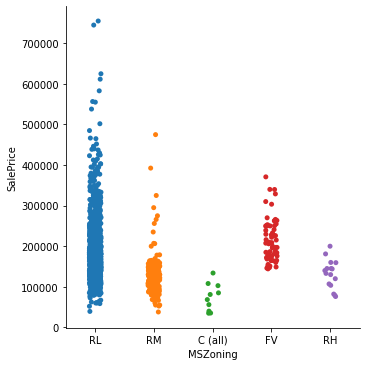

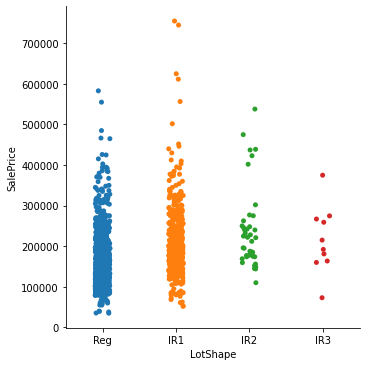

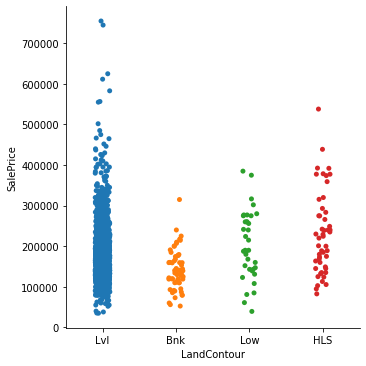

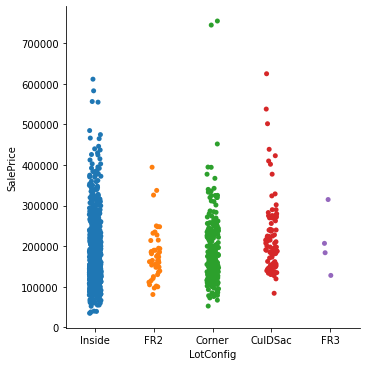

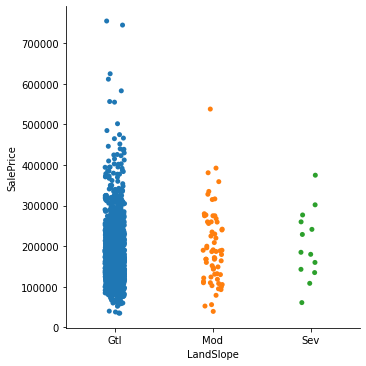

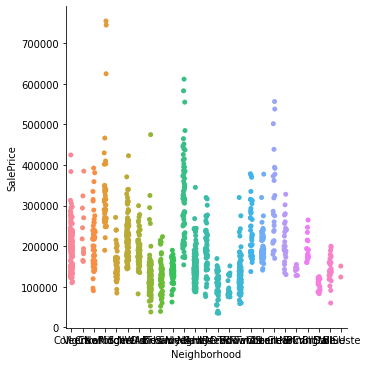

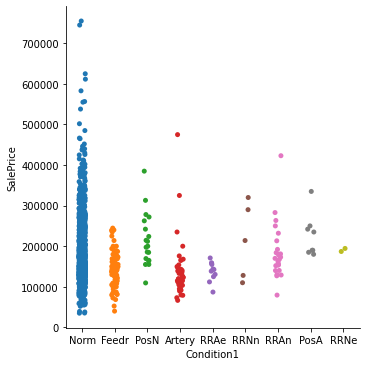

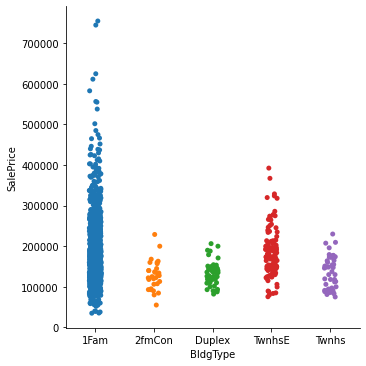

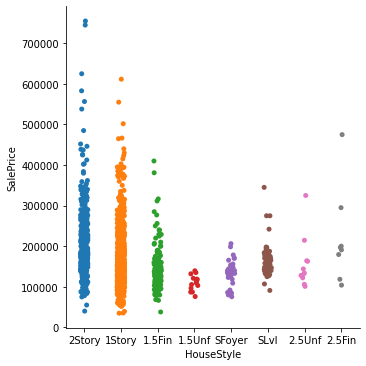

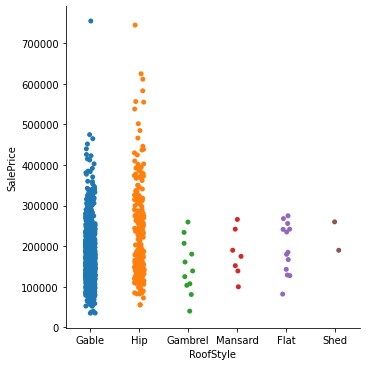

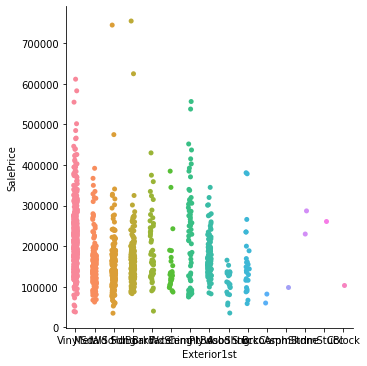

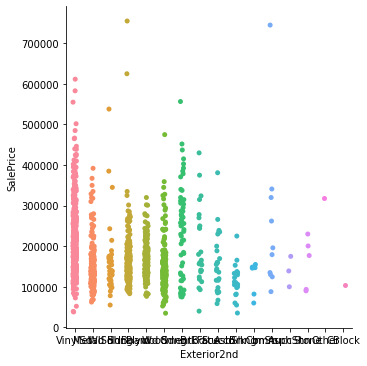

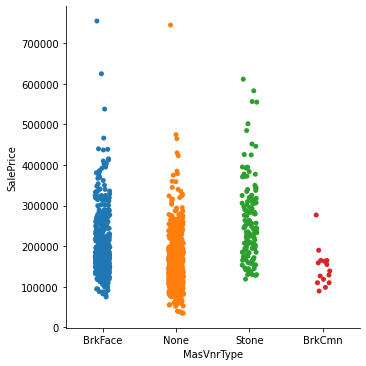

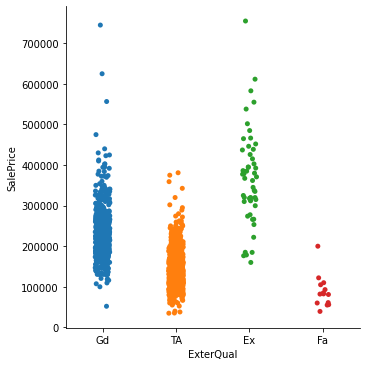

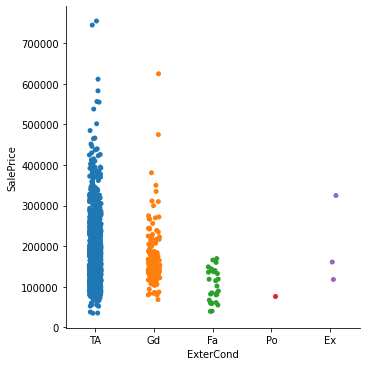

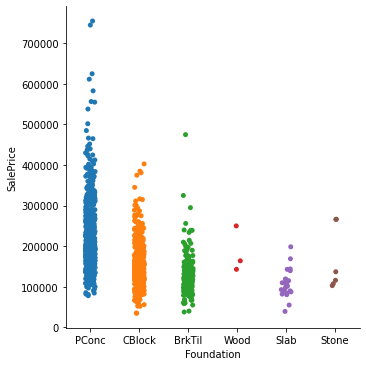

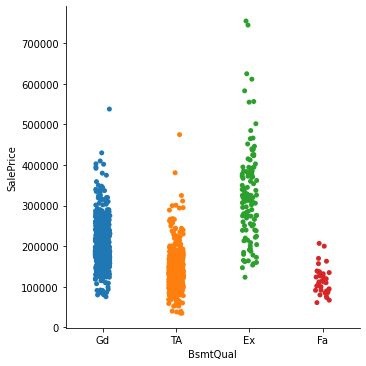

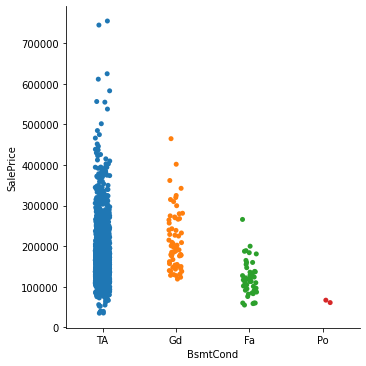

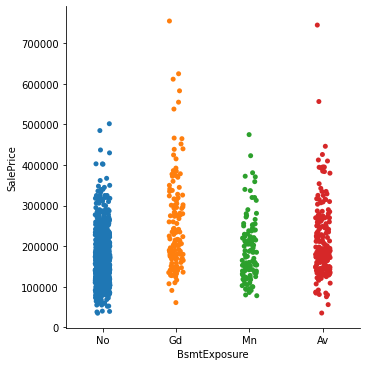

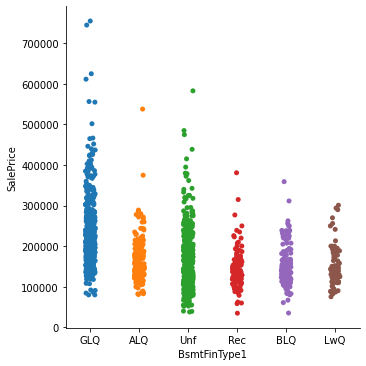

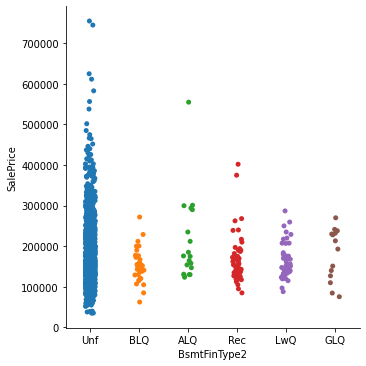

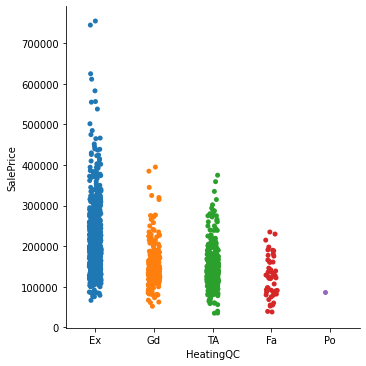

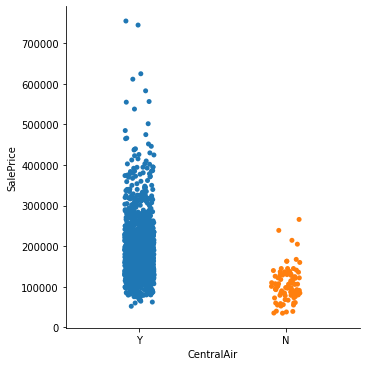

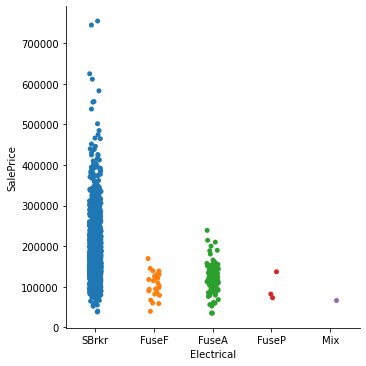

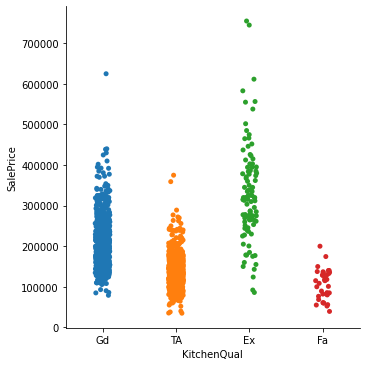

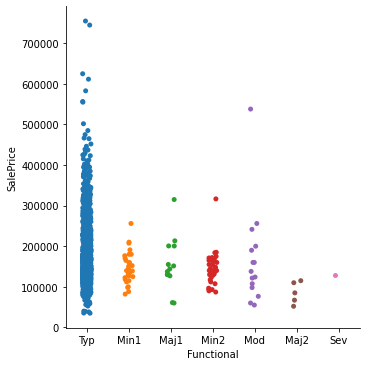

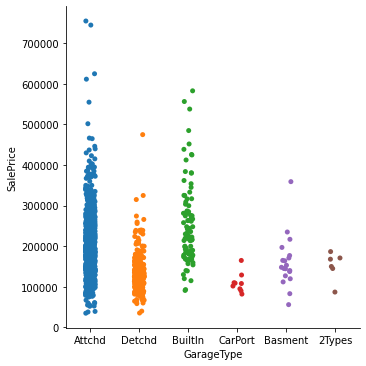

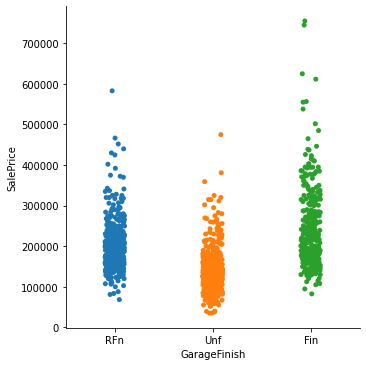

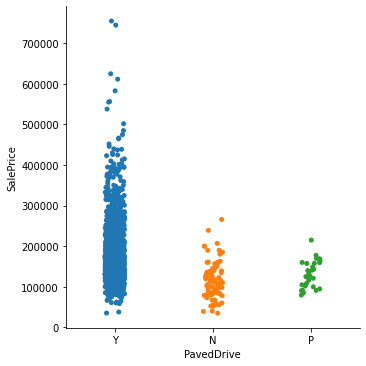

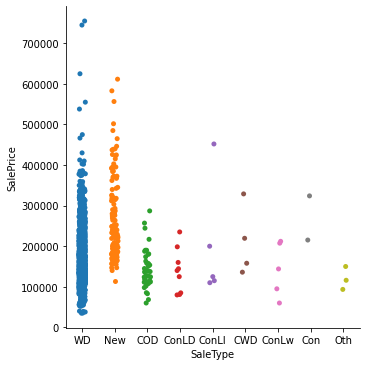

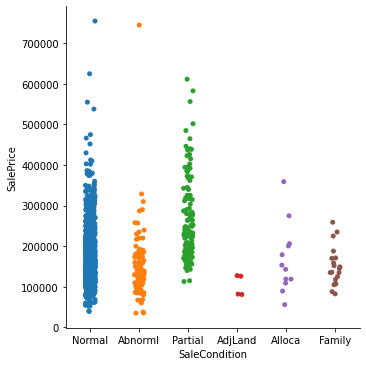

In [23]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    sns.catplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'], data=df_for_learning)
    plt.show()

Numerical features:

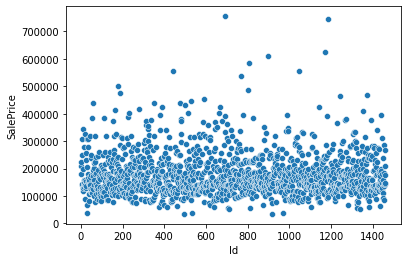

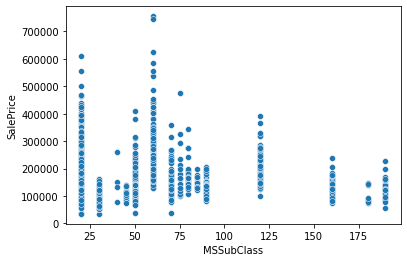

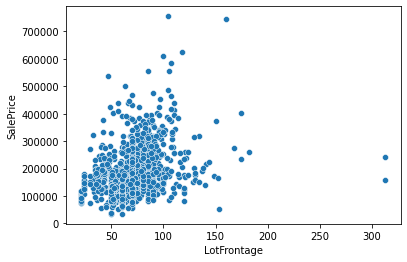

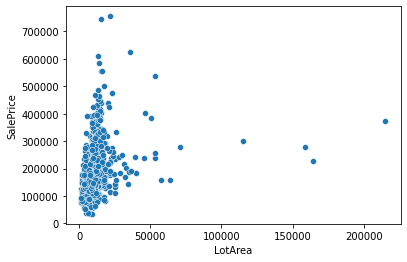

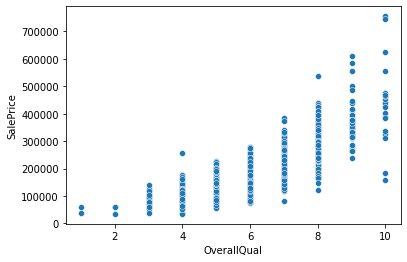

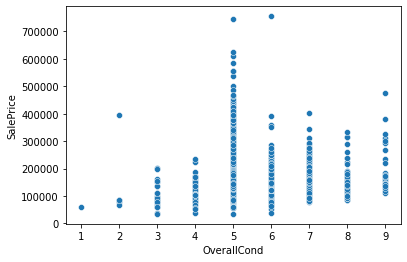

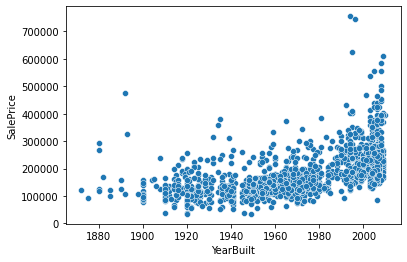

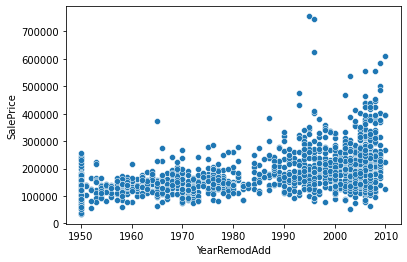

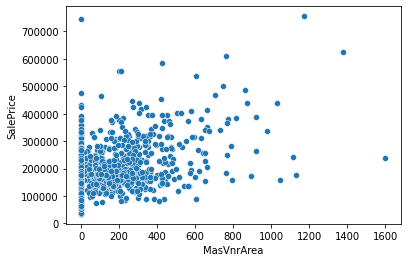

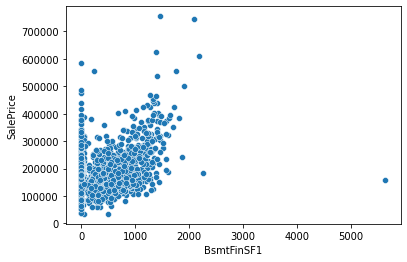

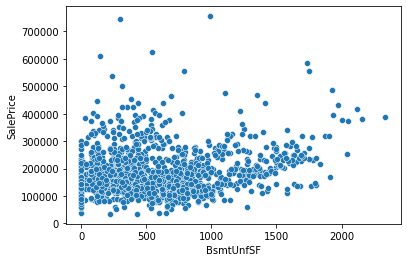

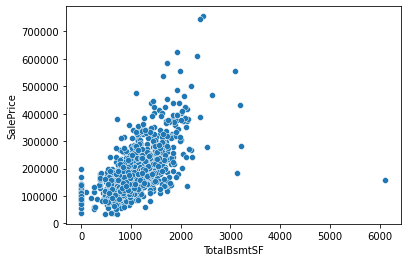

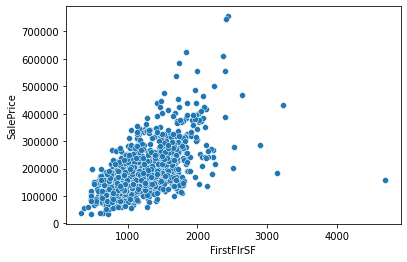

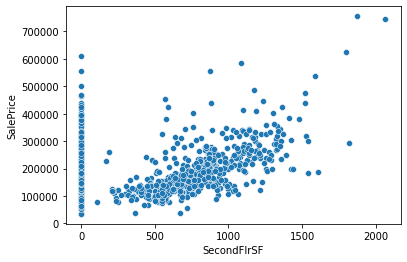

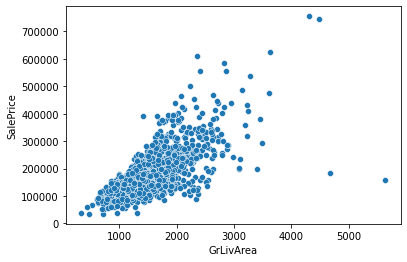

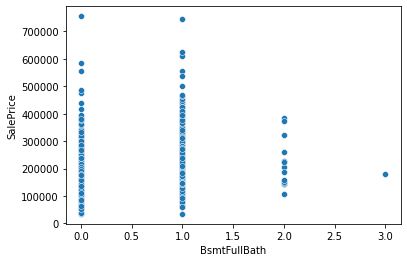

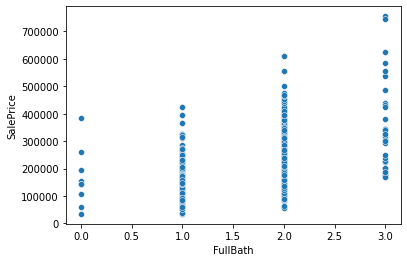

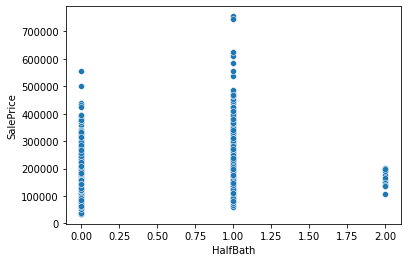

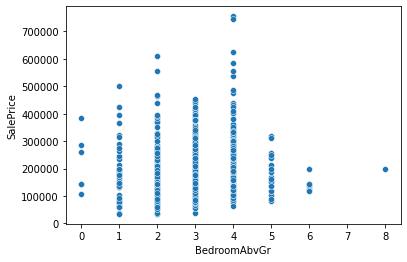

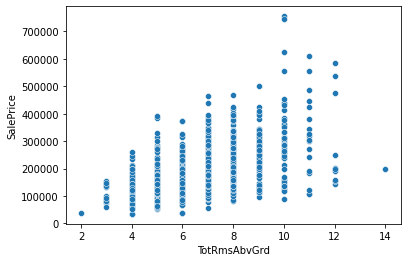

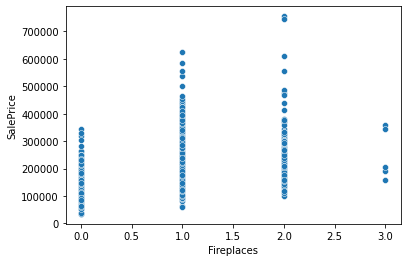

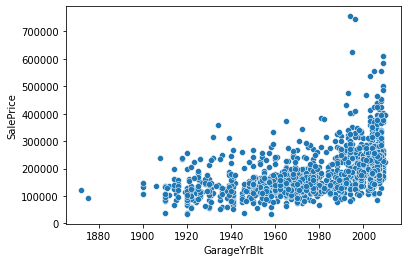

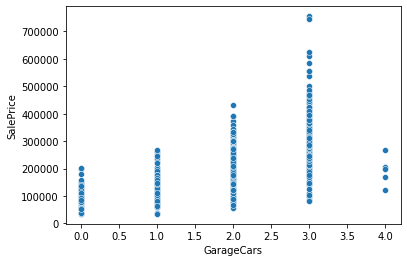

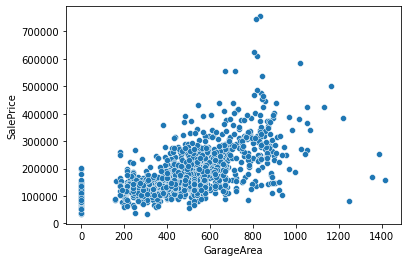

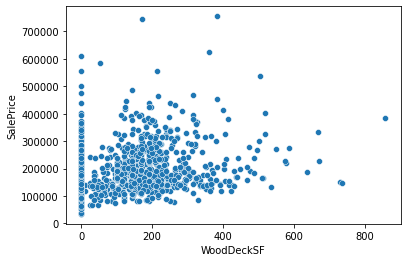

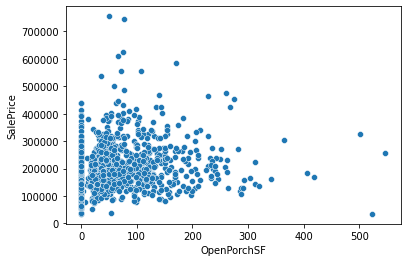

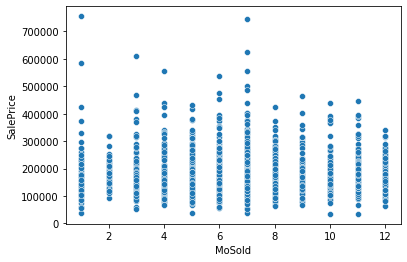

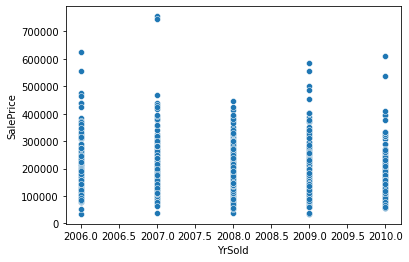

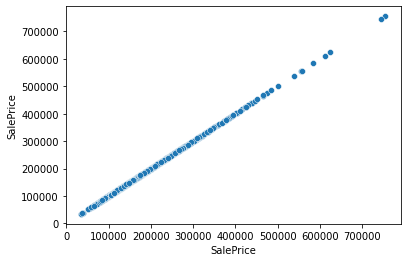

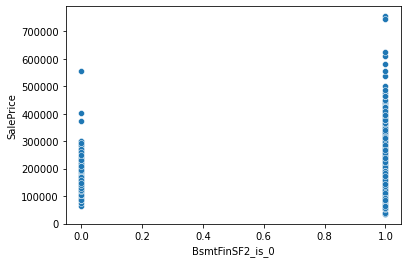

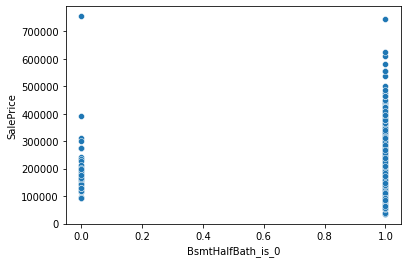

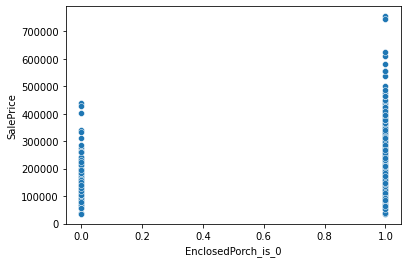

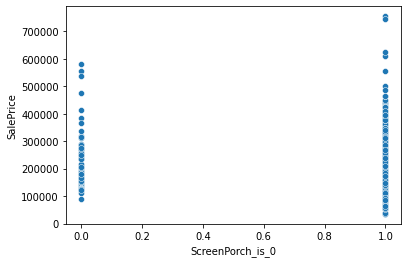

In [24]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'])
    plt.show()

Looking at the graphs above we may see outliers just visually and remove them

In [25]:
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.HeatingQC != 'Po']
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.GrLivArea < 4500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.SalePrice < 700000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotRmsAbvGrd < 14]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.OpenPorchSF < 500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.WoodDeckSF < 800]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BedroomAbvGr < 8]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.FirstFlrSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotalBsmtSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFinSF1 < 5000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.MasVnrArea < 1500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotArea < 100000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotFrontage < 200]

looking at the graphs above, we can conclude that some features are not important (mutual distribution with target variable is uniform) and may be removed

In [26]:
not_importatnt = ["Exterior1st","Exterior2nd","Foundation","YrSold"]
df_for_learning_no_missing = df_for_learning_no_missing.drop(columns = not_importatnt)
df_for_test_no_missing = df_for_test_no_missing.drop(columns = not_importatnt)

As we can also see, some numerical features may be transformed into categorical features, because they have only a short range of values

In [27]:
def numerical_to_object(df_tr, df_test):
    threshold = 30
    numerical_features = get_num_features_for_train(df_tr)
    for feature in numerical_features:
        if len(df_tr[feature].value_counts()) < threshold:
            df_tr[feature] = df_tr[feature].apply(lambda x: str(x))
            df_test[feature] = df_test[feature].apply(lambda x: str(x))

In [28]:
numerical_to_object(df_for_learning_no_missing, df_for_test_no_missing)

## Feature engineering

In [29]:
def make_new_features(data_frame):
    data_frame['OverallQualSquared'] = data_frame['OverallQual'] * data_frame['OverallQual']
    data_frame['GarageYrBltSquared'] = data_frame['GarageYrBlt'] * data_frame['GarageYrBlt']
    data_frame['SecondFlrSFSquared'] = data_frame['SecondFlrSF'] * data_frame['SecondFlrSF']
    data_frame['YearBuiltSquared'] = data_frame['YearBuilt'] * data_frame['YearBuilt']
    return data_frame

In [30]:
# df_for_learning_no_missing = make_new_features(df_for_learning_no_missing)
# df_for_test_no_missing = make_new_features(df_for_test_no_missing)

## Correlation Analysis

In [31]:
from scipy.stats import spearmanr
corr_for_SalePrice = {}
for feature in df_for_learning_no_missing.columns:
    corr_for_SalePrice[feature] = spearmanr(df_for_learning_no_missing['SalePrice'], 
                                       df_for_learning_no_missing[feature])[0]
corr_for_SalePrice = pd.DataFrame(data = corr_for_SalePrice.values(), index = corr_for_SalePrice.keys(), columns = ['Corr_Value'])

In [32]:
corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)
corr_for_SalePrice

,Corr_Value
SalePrice,1.000000
OverallQual,0.758016
GrLivArea,0.727624
GarageCars,0.693308
YearBuilt,0.663574
GarageArea,0.649979
FullBath,0.635633
ExterQual,-0.634976
GarageYrBlt,0.621937
GarageFinish,-0.621077


In [33]:
less_corr_features = corr_for_SalePrice.index[abs(corr_for_SalePrice["Corr_Value"]) < 0.1]
less_corr_features = list(less_corr_features)
less_corr_features

['ScreenPorch_is_0',
 'BsmtFinType1',
 'MSSubClass',
 'MasVnrType',
 'LotConfig',
 'BsmtFinType2',
 'BsmtFinSF2_is_0',
 'LandSlope',
 'BsmtCond',
 'MoSold',
 'BsmtHalfBath_is_0',
 'Id',
 'LandContour']

Remove all features only a little bit correlated with the SalePrice column (let it be less than 10%)

In [34]:
df_for_learning_no_missing.drop(less_corr_features,axis = 1, inplace = True)
df_for_test_no_missing.drop(less_corr_features,axis = 1, inplace = True)

In [35]:
obj_features = df_for_learning_no_missing.select_dtypes(include=['object']).columns
numerical_features = df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns
binary_features = df_for_learning_no_missing.select_dtypes(include=['bool']).columns

In [36]:
df_for_corr = df_for_learning_no_missing.copy()
LE =LabelEncoder()
for obj_feature in obj_features:
    df_for_corr[obj_feature] = LE.fit_transform(df_for_corr[obj_feature])

Correlation between categorical features

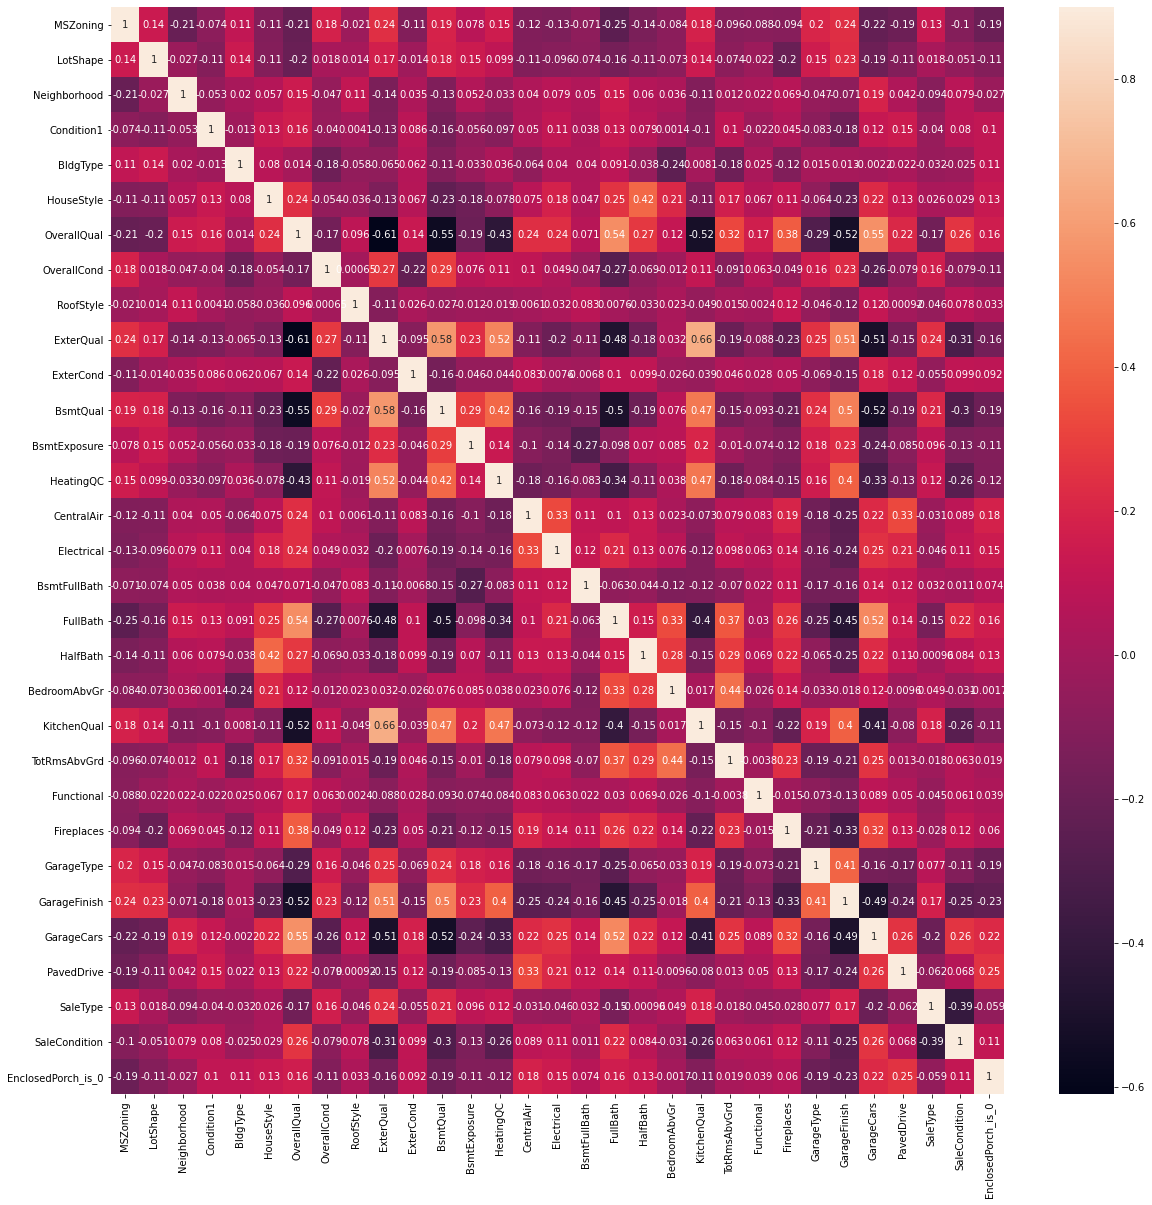

In [37]:
corr_matrix = df_for_corr[obj_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(20,20)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

Correlation between numerical features

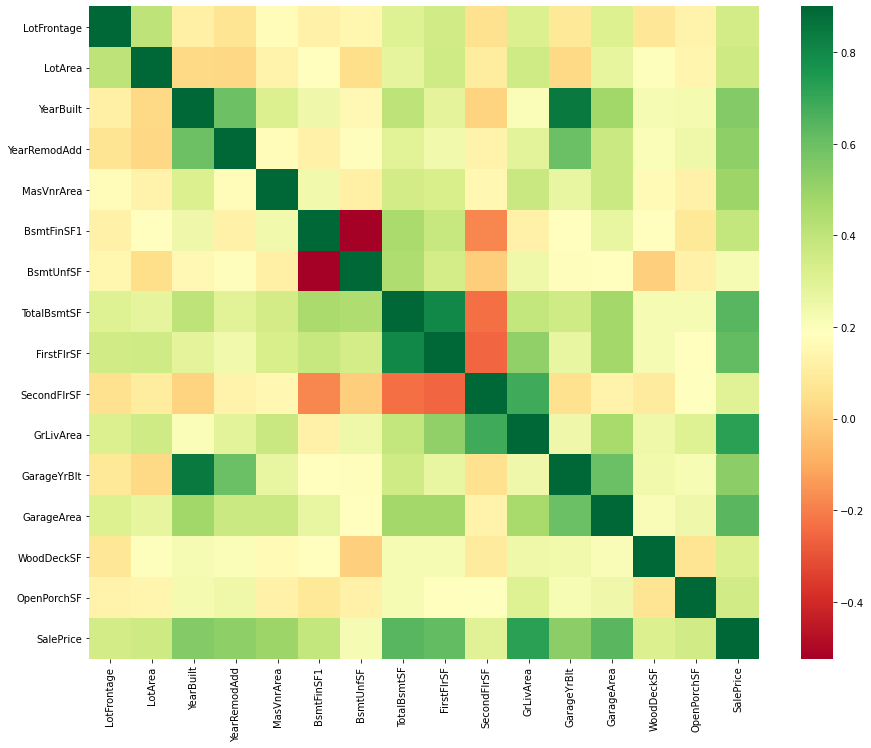

In [38]:
corr_matrix = df_for_corr[numerical_features].corr('pearson')
f, ax1 = plt.subplots(figsize=(15,12)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

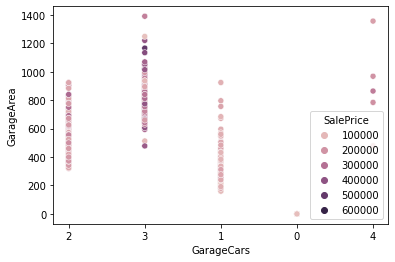

In [39]:
sns.scatterplot(data = df_for_learning_no_missing, x = 'GarageCars', y = 'GarageArea', hue = 'SalePrice')

In [40]:
def remove_correlated_features(df):
    columns_to_drop = ['GarageYrBlt','GarageArea','FirstFlrSF','BedroomAbvGr','BsmtFullBath','ExterQual','HeatingQC','BsmtQual']
    df.drop(columns = columns_to_drop, inplace = True)
    return df
# df_for_learning_no_missing = remove_correlated_feature(df_for_learning_no_missing)
# df_for_test_no_missing = remove_correlated_feature(df_for_test_no_missing)

In [41]:
df_for_learning_no_missing.describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,69.572966,9989.979903,1971.361053,1984.846847,101.337132,434.105336,567.844075,1048.376992,1154.312543,342.647263,1502.516286,1976.596674,471.724879,93.201663,45.313929,179604.536383
std,19.868508,5298.546396,30.142874,20.641433,172.602051,428.293815,442.239359,411.169563,367.615467,430.127001,492.369936,26.253951,211.103934,122.775040,61.802484,76267.300147
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,1872.000000,0.000000,0.000000,0.000000,35311.000000
25%,60.000000,7517.500000,1954.000000,1967.000000,0.000000,0.000000,223.500000,795.000000,882.000000,0.000000,1128.000000,1959.000000,329.000000,0.000000,0.000000,129900.000000
50%,70.049958,9450.000000,1973.000000,1994.000000,0.000000,378.000000,480.000000,990.000000,1082.000000,0.000000,1456.000000,1978.000000,478.000000,0.000000,24.000000,162000.000000
75%,79.000000,11506.000000,2001.000000,2004.000000,163.500000,705.500000,808.000000,1285.000000,1381.500000,728.000000,1768.000000,2001.000000,576.000000,168.000000,67.500000,213000.000000
max,182.000000,70761.000000,2010.000000,2010.000000,1378.000000,2188.000000,2336.000000,3206.000000,3228.000000,1818.000000,3627.000000,2010.000000,1390.000000,736.000000,418.000000,625000.000000


## Some preparations before train

<AxesSubplot:>

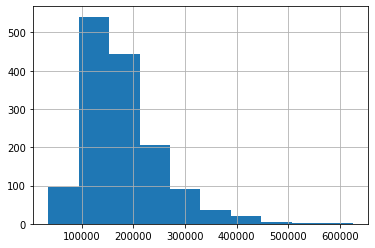

In [42]:
df_for_learning_no_missing['SalePrice'].hist()

<AxesSubplot:>

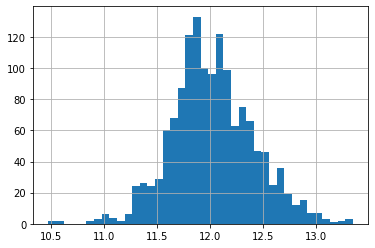

In [43]:
np.log1p(df_for_learning_no_missing['SalePrice']).hist(bins=40)

Obviously, target variable is normally distributed, so we may use 3-sigma rule to remove outliers

removing outliers

In [44]:
def dealing_with_outliers(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = list(df.select_dtypes(include=['int64','float64']).columns)
    if 'SalePrice' in int_features:
        int_features.remove('SalePrice')
#     Q1 = df[int_features].quantile(0.25)
#     Q3 = df[int_features].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 -(1.5 * IQR) 
#     upper_bound = Q3 +(1.5 * IQR)
#     Q1 = df['SalePrice'].quantile(0.25)
#     Q3 = df['SalePrice'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 -(1.5 * IQR) 
#     upper_bound = Q3 +(1.5 * IQR)
#     df = df[(df['SalePrice'] > lower_bound) & (df['SalePrice'] < upper_bound)]
#     for col in df[int_features]:
#          Q1 = df[col].quantile(0.25)
#          Q3 = df[col].quantile(0.75)
#          IQR = Q3 - Q1
#          lower_bound = Q1 -(1.5 * IQR) 
#          upper_bound = Q3 +(1.5 * IQR)
#          df[col] = df[col].apply(lambda x: x if x>lower_bound else lower_bound) 
#          df[col] = df[col].apply(lambda x: x if x<upper_bound else  upper_bound) 
#     df = df[~((df[int_features] < (Q1 - 1.5 * IQR)) |(df[int_features] > (Q3 + 1.5 * IQR))).any(axis=1)]
    for feature in obj_features:
        counts = df[feature].value_counts()
        df = df[df[feature].isin(counts[counts > 2].index)]
#     for int_feature in int_features:
#         df[int_feature] = df[int_feature].map(lambda i: np.log(i) if i > 0 else 0) 
#     z = np.abs(stats.zscore(df[int_features]))
#     df = df[(z < 3).all(axis=1)]
    #df = df.reset_index()
#     df['z'] = np.abs(stats.zscore(df['SalePrice']))
#     df = df[df['z'] < 3]
#     df.drop(columns = ['z'], inplace = True)
    return df

In [45]:
# df_for_learning_no_missing = dealing_with_outliers(df_for_learning_no_missing)

In [46]:
df_for_learning_no_missing.describe

<bound method NDFrame.describe of      MSZoning  LotFrontage  LotArea LotShape Neighborhood Condition1 BldgType  \
0          RL         65.0     8450      Reg      CollgCr       Norm     1Fam   
1          RL         80.0     9600      Reg      Veenker      Feedr     1Fam   
2          RL         68.0    11250      IR1      CollgCr       Norm     1Fam   
3          RL         60.0     9550      IR1      Crawfor       Norm     1Fam   
4          RL         84.0    14260      IR1      NoRidge       Norm     1Fam   
...       ...          ...      ...      ...          ...        ...      ...   
1455       RL         62.0     7917      Reg      Gilbert       Norm     1Fam   
1456       RL         85.0    13175      Reg       NWAmes       Norm     1Fam   
1457       RL         66.0     9042      Reg      Crawfor       Norm     1Fam   
1458       RL         68.0     9717      Reg        NAmes       Norm     1Fam   
1459       RL         75.0     9937      Reg      Edwards       Norm     1F

In [47]:
df_for_learning_no_missing = df_for_learning_no_missing.reset_index(drop = True)
df_for_test_no_missing = df_for_test_no_missing.reset_index(drop = True)

## Data transfromation using StandardScaler, PCA and NonLinearTranformation

In [48]:
def get_StandardScaler(train_df):
    numerical_features = get_num_features_for_train(train_df)
    Scaler = StandardScaler()
    num_data = train_df[numerical_features]
    Scaler = StandardScaler().fit(num_data)
    return Scaler

In [49]:
def get_PCA_transformer(train_df, Scaler):
    numerical_features = get_num_features_for_train(train_df)
    pca = PCA(0.95)
    num_data = train_df[numerical_features]
    num_data = Scaler.transform(num_data)
    pca.fit(num_data)
    return pca

In [50]:
def pca_transform(df, pca_fitted_on_train):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    principalComponents = pca_fitted_on_train.transform(num_data)
    n_components = principalComponents.shape[1]
    pca_col_names = ["pca_{}".format(i+1) for i in range(n_components)]
    pca_data_frame = pd.DataFrame(data = principalComponents
             , columns = pca_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, pca_data_frame], axis = 1)
    return df

In [51]:
def scale_numerical_df(df, Scaler):
    numerical_features = get_num_features_for_train(df)
    #Scaler = RobustScaler()
    df[numerical_features] = Scaler.transform(df[numerical_features])
    return df

In [52]:
def get_isomap_transformer(train_df, std_scaler, pca_transformer):
    numerical_features = get_num_features_for_train(train_df)
    isomap = Isomap(n_components=3)
    num_data = train_df[numerical_features]
    num_data = std_scaler.transform(num_data)
    num_data = pca_transformer.transform(num_data)
    isomap.fit(num_data)
    return isomap

In [53]:
def isomap_transform(df, isomap_transformer):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    num_data = isomap_transformer.transform(num_data)
    isomap_col_names = ["isomap_{}".format(i+1) for i in range(3)]
    isomap_data_frame = pd.DataFrame(data = num_data
             , columns = isomap_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, isomap_data_frame], axis = 1)
    return df

Data Normalization (numerical features)

In [54]:
train_data, val_data, train_value, val_value = train_test_split(df_for_learning_no_missing.drop(columns = "SalePrice"), df_for_learning_no_missing.SalePrice, test_size = 0.2, random_state=2021 )

In [55]:
train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
train_value.reset_index(drop = True, inplace = True)
val_value.reset_index(drop = True, inplace = True)

In [56]:
train_data

,MSZoning,LotFrontage,LotArea,LotShape,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,EnclosedPorch_is_0
0,RL,65.000000,10237,Reg,Gilbert,RRAn,1Fam,2Story,6,5,...,2005.0,Fin,2,393,Y,0,72,New,Partial,1
1,RL,42.000000,14892,IR1,Gilbert,Norm,1Fam,1Story,9,5,...,2006.0,Fin,3,758,Y,201,39,WD,Normal,1
2,RL,70.000000,9100,Reg,NAmes,Norm,1Fam,1Story,6,6,...,2008.0,Unf,1,300,Y,0,0,WD,Normal,1
3,RL,75.000000,7950,IR1,Edwards,Norm,1Fam,2Story,6,6,...,1977.0,Fin,2,440,Y,252,0,WD,Normal,1
4,RL,61.000000,7930,Reg,NAmes,Norm,1Fam,1Story,6,8,...,1969.0,RFn,2,440,Y,171,48,WD,Normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,RM,50.000000,9000,Reg,OldTown,Artery,1Fam,2Story,5,6,...,1937.0,Unf,1,240,N,0,0,WD,Abnorml,0
1150,RL,64.000000,10475,IR1,CollgCr,Norm,1Fam,1Story,8,5,...,2008.0,RFn,3,776,Y,160,33,WD,Normal,1
1151,RL,66.000000,13682,IR2,StoneBr,Norm,1Fam,2Story,10,5,...,2006.0,Fin,3,641,Y,192,0,New,Partial,0
1152,RM,60.000000,7200,Reg,OldTown,Norm,1Fam,2Story,7,7,...,1989.0,Unf,2,576,N,36,0,WD,Normal,0


In [57]:
std_scaler = get_StandardScaler(train_data)
pca_transformer = get_PCA_transformer(train_data, std_scaler)
isomap_transformer = get_isomap_transformer(train_data, std_scaler, pca_transformer)

In [58]:
train_data = scale_numerical_df(train_data, std_scaler)
val_data = scale_numerical_df(val_data, std_scaler)
df_for_test_no_missing = scale_numerical_df(df_for_test_no_missing, std_scaler)

In [59]:
# train_data = pca_transform(train_data, pca_transformer)
# val_data = pca_transform(val_data, pca_transformer)
# df_for_test_no_missing = pca_transform(df_for_test_no_missing, pca_transformer)

In [60]:
# train_data = isomap_transform(train_data, isomap_transformer)
# val_data = isomap_transform(val_data, isomap_transformer)
# df_for_test_no_missing = isomap_transform(df_for_test_no_missing, isomap_transformer)

After PCA all numerical components become ortogonal

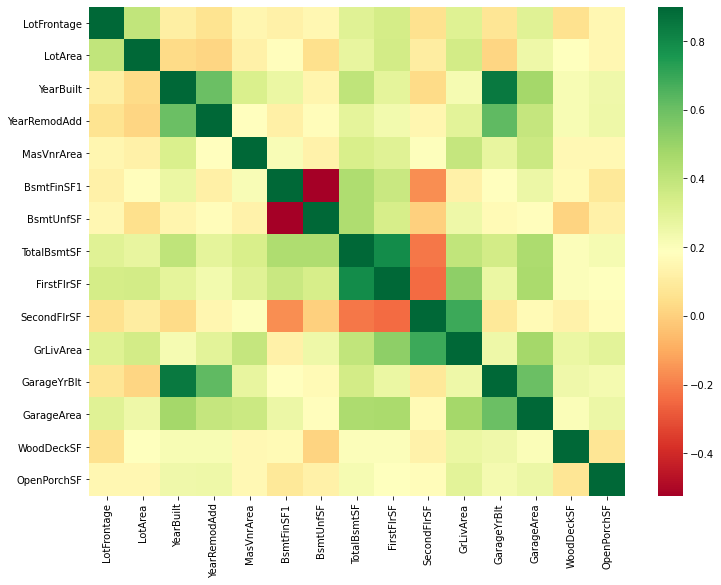

In [61]:
numerical_features  = list(train_data.select_dtypes(include=['int64','float64']).columns)
corr_matrix = train_data[numerical_features].corr('pearson')
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

<AxesSubplot:>

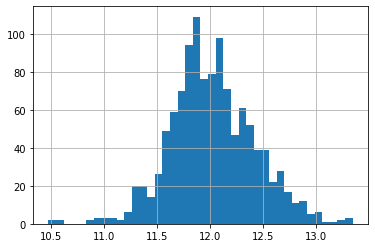

In [62]:
np.log1p(train_value).hist(bins=40)

<AxesSubplot:>

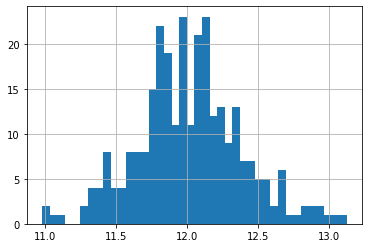

In [63]:
np.log1p(val_value).hist(bins=40)

So we can see the target variable approximately disributed the same way between train and validation datasets

In [64]:
cat_features = list(df_for_learning_no_missing.select_dtypes(include=['object','bool']).columns)
train_pool = catboost.Pool(
    train_data,
    label=train_value,
    cat_features = cat_features
)
val_pool = catboost.Pool(
    val_data,
    label = val_value,
    cat_features = cat_features
)

In [65]:
catboost_train_dir = 'catboost_train_dir'
!rmdir /S /Q catboost_train_dir
!mkdir catboost_train_dir

In [ ]:
regr_model = catboost.CatBoostRegressor(
    # early_stopping_rounds=20,
    random_seed=2021,
    depth = 5,
    od_pval=0.05,
    od_wait=20,
    loss_function='RMSE',
    #learning_rate=0.1,
    iterations = 3000,
    train_dir=catboost_train_dir,
    task_type='GPU',
    # task_type='CPU',
    # devices='0',
    #auto_class_weights='Balanced',
    max_ctr_complexity=4,
    l2_leaf_reg = 1,
    use_best_model=True
)
regr_model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76433.4014541	test: 70188.8614655	best: 70188.8614655 (0)	total: 64.3ms	remaining: 3m 12s
1:	learn: 75438.9965481	test: 69261.0415928	best: 69261.0415928 (1)	total: 134ms	remaining: 3m 20s
2:	learn: 74481.0805336	test: 68308.1647342	best: 68308.1647342 (2)	total: 194ms	remaining: 3m 13s
3:	learn: 73372.8027747	test: 67240.3535454	best: 67240.3535454 (3)	total: 268ms	remaining: 3m 20s
4:	learn: 72422.1988094	test: 66288.4861946	best: 66288.4861946 (4)	total: 349ms	remaining: 3m 29s
5:	learn: 71365.5311392	test: 65274.4955682	best: 65274.4955682 (5)	total: 433ms	remaining: 3m 36s
6:	learn: 70389.4663870	test: 64358.2265721	best: 64358.2265721 (6)	total: 512ms	remaining: 3m 38s
7:	learn: 69550.1527333	test: 63575.4210041	best: 63575.4210041 (7)	total: 589ms	remaining: 3m 40s
8:	learn: 68749.8621809	test: 62791.1193985	best: 62791.1193985 (8)	total: 674ms	remaining: 3m 43s
9:	learn: 67855.8657750	test: 61957.9881003	best: 61957.9881003 (9)	total: 757ms	remaining: 3m 46s
10:	learn

83:	learn: 38177.1643713	test: 34397.8784636	best: 34397.8784636 (83)	total: 6.75s	remaining: 3m 54s
84:	learn: 37950.7189908	test: 34237.6667963	best: 34237.6667963 (84)	total: 6.82s	remaining: 3m 53s
85:	learn: 37808.7602690	test: 34118.8429681	best: 34118.8429681 (85)	total: 6.9s	remaining: 3m 53s
86:	learn: 37583.0629120	test: 34038.1047618	best: 34038.1047618 (86)	total: 6.97s	remaining: 3m 53s
87:	learn: 37440.6263527	test: 33908.4331522	best: 33908.4331522 (87)	total: 7.07s	remaining: 3m 53s
88:	learn: 37281.0760134	test: 33785.6829578	best: 33785.6829578 (88)	total: 7.16s	remaining: 3m 54s
89:	learn: 37091.4194400	test: 33651.5163086	best: 33651.5163086 (89)	total: 7.24s	remaining: 3m 54s
90:	learn: 36969.0903374	test: 33531.0989313	best: 33531.0989313 (90)	total: 7.32s	remaining: 3m 54s
91:	learn: 36761.3560402	test: 33425.9549518	best: 33425.9549518 (91)	total: 7.4s	remaining: 3m 53s
92:	learn: 36613.5160368	test: 33331.5042503	best: 33331.5042503 (92)	total: 7.48s	remaining:

limit_output extension: Maximum message size of 10000 exceeded with 10171 characters

Write SalePrice prediction for test values in file

In [ ]:
df_to_csv = pd.DataFrame()
df_to_csv['SalePrice'] = regr_model.predict(df_for_test_no_missing)
df_to_csv['Id'] = df_test_id
df_to_csv.to_csv('answer.csv', index = False)

## Post-Hoc analysis

In [ ]:
features_importance = sorted(
    zip(train_data.columns, regr_model.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)
important_features_cumulative = np.cumsum([feature[1] for feature in features_importance], axis = 0)
features_importance = pd.DataFrame(features_importance)
features_importance.columns = ['Feature','Feature_importance']
features_importance['Cumulative_sum'] = important_features_cumulative
features_importance['CorrWithSalePrice'] = [stats.spearmanr(train_value, train_data[feature])[0]
                                            for feature in features_importance['Feature']]
features_importance

As we can see many important feautres also have strong correlation with the SalePrice, except NeigborHood (maybe because it is a categorical feature)

In [ ]:
shap_info = regr_model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

In [ ]:
shap_values.shape

In [ ]:
shap.summary_plot(shap_values, train_data)